## 1. Importações e Configurações

In [2]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(project_root)

from src.forecasting import (
    load_and_prepare_data,
    create_features,
    train_and_predict
)

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Parâmetros Iniciais

In [5]:
# Loja para análise (pode mudar para testar outras)
STORE_ID = 1

# Quantos dias usar como teste (hold-out final)
TEST_DAYS = 60

# Caminho dos dados (relativo à pasta notebooks)
DATA_PATH = 'data/'

## 3. Carregamento e Exploração Rápida dos Dados

In [6]:
# Carrega e prepara os dados para a loja escolhida
df = load_and_prepare_data(store_id=STORE_ID, data_path=DATA_PATH)

print(f"Shape após preparação: {df.shape}")
print(f"Período: {df.index.min()} até {df.index.max()}")
df.head()

Shape após preparação: (781, 1)
Período: 2013-01-02 00:00:00 até 2015-07-31 00:00:00


,Sales
Date,
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
2013-01-07,7176


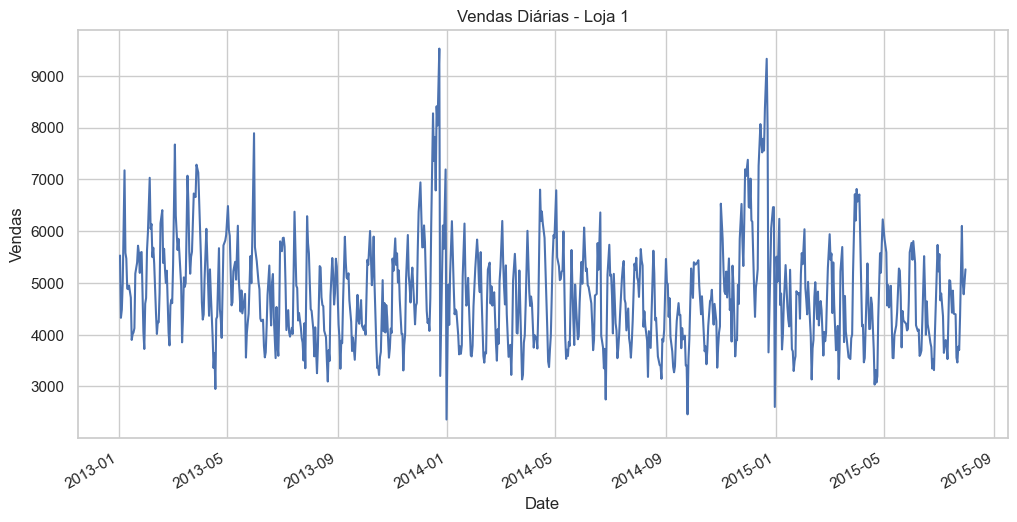

In [7]:
# Visualização rápida da série bruta
df['Sales'].plot(title=f'Vendas Diárias - Loja {STORE_ID}')
plt.ylabel('Vendas')
plt.show()

## 4. Feature Engineering e Treinamento

In [8]:
# Usa a função modularizada para tudo: features + split + treino + predição
model, dates, y_real, y_pred, mae = train_and_predict(
    store_id=STORE_ID,
    test_days=TEST_DAYS
)

print(f"\nMAE no período de teste ({TEST_DAYS} dias): {mae:.2f}")
print(f"Média de vendas reais no teste: {y_real.mean():.2f}")
print(f"Erro relativo médio: {(mae / y_real.mean() * 100):.2f}%")


MAE no período de teste (60 dias): 301.57
Média de vendas reais no teste: 4440.33
Erro relativo médio: 6.79%


## 5. Visualização dos Resultados

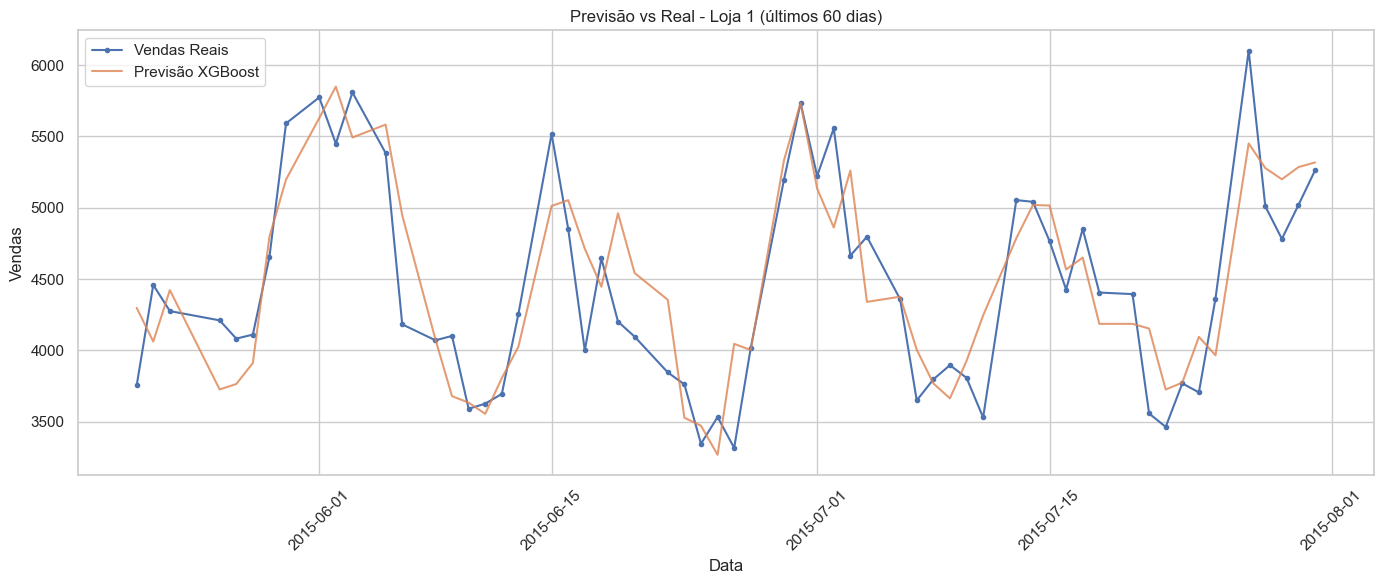

In [9]:
# Gráfico completo do período de teste
plt.figure(figsize=(14, 6))
plt.plot(dates, y_real, label='Vendas Reais', marker='o', markersize=3)
plt.plot(dates, y_pred, label='Previsão XGBoost', alpha=0.8)
plt.title(f'Previsão vs Real - Loja {STORE_ID} (últimos {TEST_DAYS} dias)')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

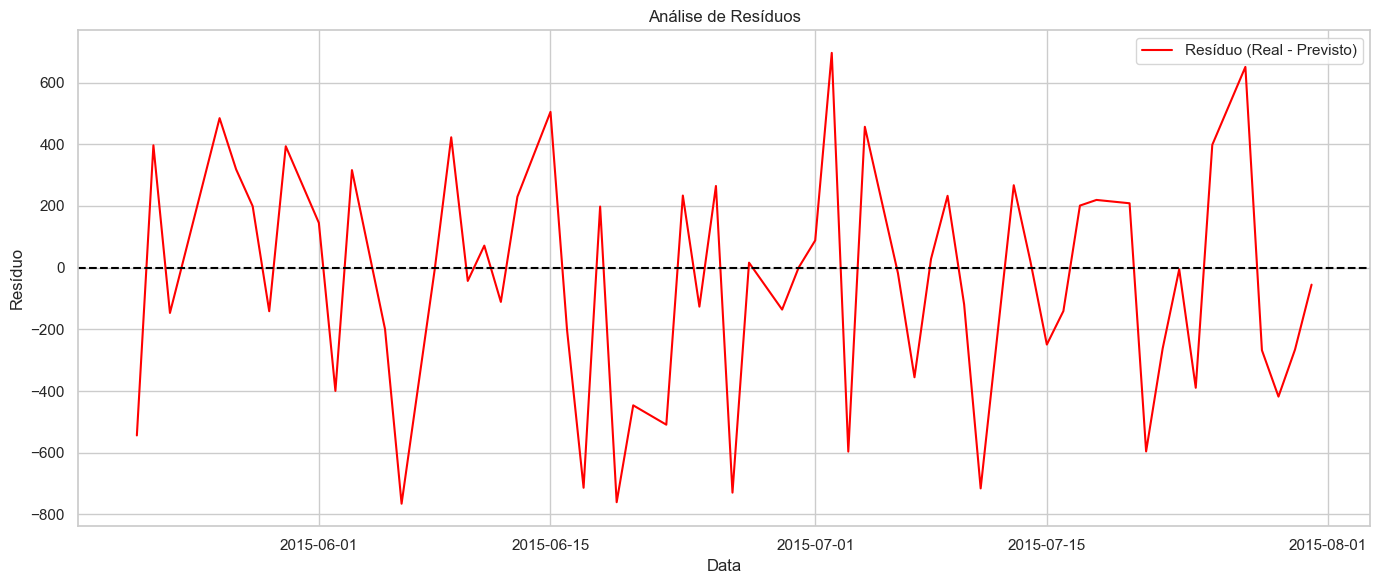

Desvio padrão dos resíduos: 371.67


In [10]:
# Gráfico de resíduos (erros)
residuos = y_real - y_pred
plt.figure(figsize=(14, 6))
plt.plot(dates, residuos, label='Resíduo (Real - Previsto)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Análise de Resíduos')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Desvio padrão dos resíduos: {residuos.std():.2f}")

## 6. Previsão Futura (próximos 60 dias)

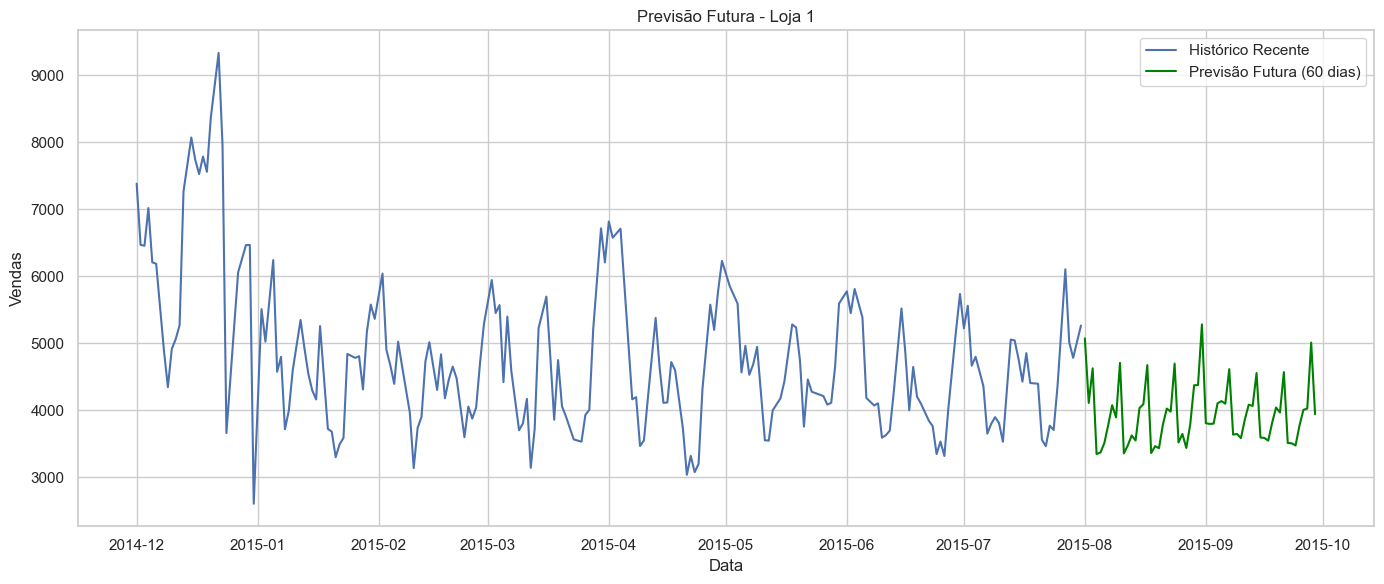

Previsão média para os próximos 60 dias: 3943.04


In [11]:
# Para prever dias futuros, precisamos estender o dataframe com features continuadas
def predict_future(model, last_df, periods=60):
    last_date = last_df.index.max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=periods)
    
    # Cria dataframe futuro e preenche features manualmente
    future_df = pd.DataFrame(index=future_dates)
    full_df = pd.concat([last_df, pd.DataFrame({'Sales': [0]*periods}, index=future_dates)])
    full_df = create_features(full_df)
    
    future_features = full_df.tail(periods).drop('Sales', axis=1)
    future_pred = model.predict(future_features)
    
    return future_dates, future_pred

# Dados completos com features (antes do split)
df_full = load_and_prepare_data(store_id=STORE_ID, data_path=DATA_PATH)
df_feat = create_features(df_full)

future_dates, future_pred = predict_future(model, df_feat, periods=60)

# Plot previsão futura
plt.figure(figsize=(14, 6))
plt.plot(df_feat.index[-200:], df_feat['Sales'][-200:], label='Histórico Recente')
plt.plot(future_dates, future_pred, label='Previsão Futura (60 dias)', color='green')
plt.title(f'Previsão Futura - Loja {STORE_ID}')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Previsão média para os próximos 60 dias: {future_pred.mean():.2f}")